# Tacking Point Estimation

In [1]:
import jax.numpy as jnp
from jax import Array
from jax import vmap

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

import os

from abc import ABC

from geometry.manifolds import LorentzFinslerManifold, nEllipsoid, nSphere, RiemannianNavigation
from geometry.geodesics import GEORCE

In [2]:
#hyper parameters
rho = 0.5
max_iter = 1000
T = 100
tol = 1e-4

In [3]:
figure_path = '../figures/tacking_estimation/'

In [4]:
plt.rcParams.update({'font.size': 25})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

In [5]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

## Tacking with Constant Finsler Geometries

### Defining Finsler Geometry

In [6]:
class EllipticFinsler(ABC):
    def __init__(self,
                 c1=1.0, 
                 c2=1.0,
                 a=1.0,
                 b=1.0,
                 theta=jnp.pi/4
                )->None:
        
        self.c1 = c1
        self.c2 = c2
        self.a = a
        self.b = b
        self.theta = theta
        
    def __call__(self, t, x, v):
        
        c1 = self.c1
        c2 = self.c2
        a = self.a
        b = self.b
        theta = self.theta
        
        x,y = v[0], v[1]
        
        a2 = a**2
        b2 = b**2
        a4 = a**4
        b4 = b**4
        c12 = c1**2
        c22 = c2**2

        f = (-a2*c2*(x*jnp.sin(theta)+y*jnp.cos(theta))-\
             b2*c1*(x*jnp.cos(theta)-y*jnp.sin(theta))+\
             (a4*b2*(x*jnp.sin(theta)+y*jnp.cos(theta))**2+\
              a2*b4*(x*jnp.cos(theta)-y*jnp.sin(theta))**2-\
              a2*b2*c12*(x*jnp.sin(theta)+y*jnp.cos(theta))**2+\
              2*a2*b2*c1*c2*(x*jnp.cos(theta)-y*jnp.sin(theta))*(x*jnp.sin(theta)+y*jnp.cos(theta))-\
              a2*b2*c22*(x*jnp.cos(theta)-y*jnp.sin(theta))**2)**(1/2))/(a2*b2-a2*c22-b2*c12)
        
        return f

In [7]:
rho=3/2
phi=jnp.pi/2+6*jnp.pi/10
theta = jnp.pi
a=2
b=2
c1 = -rho*jnp.cos(phi)
c2 = -rho*jnp.sin(phi)

Falpha = EllipticFinsler(c1=c1,c2=c2, a=a,b=b,theta=theta)
Malpha = LorentzFinslerManifold(F=Falpha)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [8]:
a=1
b=1
c1=3/4
c2=0
theta=0

Fbeta = EllipticFinsler(c1=c1,c2=c2, a=a,b=b,theta=theta)
Mbeta = LorentzFinslerManifold(F=Fbeta)

### Estimating Tack Points

In [9]:
z0 = jnp.array([0.,0.])
zT = jnp.array([2.,8.])

In [10]:
tack_metrics = [Malpha,Mbeta,Malpha,Mbeta,Malpha]
reverse_tack_metrics = [Mbeta, Malpha, Mbeta, Malpha, Mbeta]
Geodesic = GEORCE(tack_metrics, max_iter=max_iter, T=T, tol=tol, line_search_params={'rho':rho})
ReverseGeodesic = GEORCE(reverse_tack_metrics, max_iter=max_iter, T=T, tol=tol, line_search_params={'rho':rho})

In [11]:
zt_tacks = []
zt_reverse_tacks = []
for i in range(0,len(tack_metrics)):
    zt1 = Geodesic(0.0, z0, zT, n_tacks=i)
    zt2 = ReverseGeodesic(0.0, z0, zT, n_tacks=i)
    zt_tacks.append(zt1[1])
    zt_reverse_tacks.append(zt2[1])

In [12]:
indicatrix1 = Malpha.indicatrix(0.0, jnp.zeros(2), grid=jnp.linspace(-5,5,1000), eps=1e-6)
indicatrix2 = Mbeta.indicatrix(0.0, jnp.zeros(2), grid=jnp.linspace(-5,5,1000), eps=1e-6)

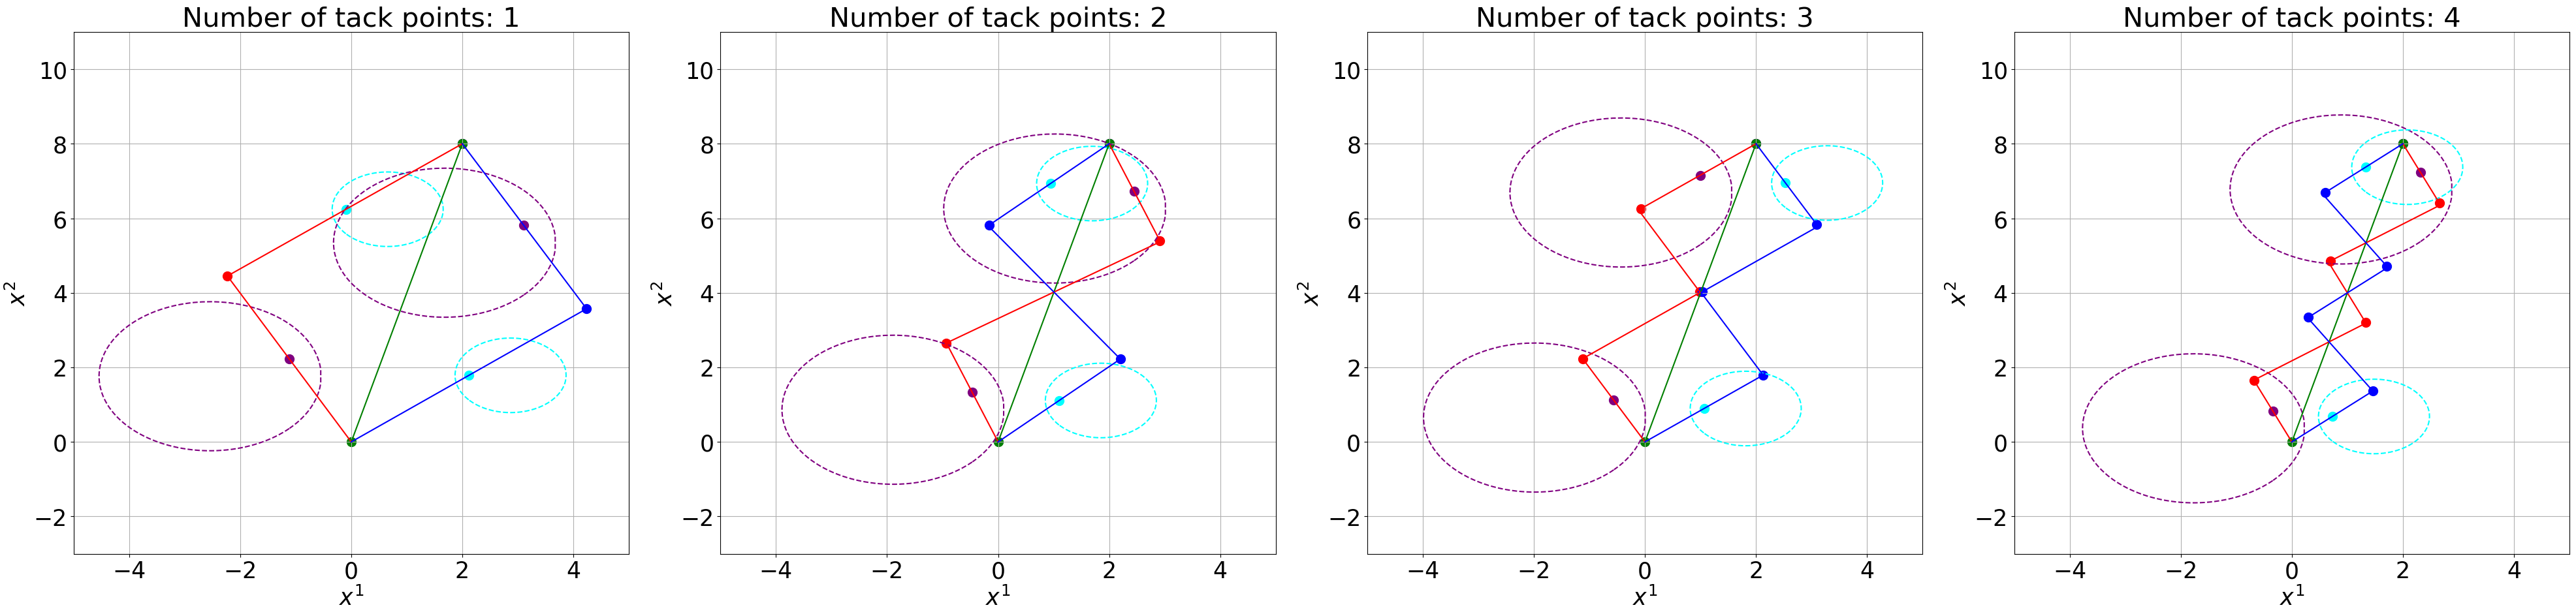

In [14]:
fig = plt.figure(figsize=((len(tack_metrics)-1)*10,10))

xscales = [-5.0, 5.0]
yscales = [-3.0, 11.0]

base_curve = zt_tacks[0]
for i in range(1,len(tack_metrics)):
    ax = fig.add_subplot(1,len(tack_metrics)-1,i)
    
    if i == 1:
        for j in range(0,i+1):
            if j % 2 == 0:
                i1_color = "purple"
                i2_color = "cyan"
                
                i1 = indicatrix1+zt_tacks[i][T//2+j*T]
                i2 = indicatrix2+zt_reverse_tacks[i][T//2+j*T]
            else:
                i1_color = "cyan"
                i2_color = "purple"
                
                i1 = indicatrix2+zt_tacks[i][T//2+j*T]
                i2 = indicatrix1+zt_reverse_tacks[i][T//2+j*T]
            ax.scatter(zt_tacks[i][T//2+j*T,0], zt_tacks[i][T//2+j*T,1], color=i1_color, s=100)
            ax.scatter(zt_reverse_tacks[i][T//2+j*T,0], zt_reverse_tacks[i][T//2+j*T,1], color=i2_color, s=100)
            ax.scatter(zt_tacks[i][T+j*T,0], zt_tacks[i][T+j*T,1], color='red', s=100)
            ax.scatter(zt_reverse_tacks[i][T+j*T,0], zt_reverse_tacks[i][T+j*T,1], color='blue', s=100)
            ax.plot(i1[:,0], i1[:,1], color=i1_color, linestyle='dashed')
            ax.plot(i2[:,0], i2[:,1], color=i2_color, linestyle='dashed')
    else:
        for j in range(0,i+1):
            ax.scatter(zt_tacks[i][T+j*T,0], zt_tacks[i][T+j*T,1], color='red', s=100)
            ax.scatter(zt_reverse_tacks[i][T+j*T,0], zt_reverse_tacks[i][T+j*T,1], color='blue', s=100)
            if (j == 0) or (j==i):
                i1_color = 'purple'
                i2_color = 'cyan'
                i1 = indicatrix1+zt_tacks[i][T//2+j*T]
                i2 = indicatrix2+zt_reverse_tacks[i][T//2+j*T]
                ax.scatter(zt_tacks[i][T//2+j*T,0], zt_tacks[i][T//2+j*T,1], color=i1_color, s=100)
                ax.scatter(zt_reverse_tacks[i][T//2+j*T,0], zt_reverse_tacks[i][T//2+j*T,1], color=i2_color, s=100)
                ax.plot(i1[:,0], i1[:,1], color=i1_color, linestyle='dashed')
                ax.plot(i2[:,0], i2[:,1], color=i2_color, linestyle='dashed')
            
    ax.scatter(z0[0], z0[1], color='green', s=100)
    ax.scatter(zT[0], zT[1], color='green', s=100)
    ax.plot(base_curve[:,0], base_curve[:,1], color='green')
    ax.plot(zt_tacks[i][:,0], zt_tacks[i][:,1], color='red')
    ax.plot(zt_reverse_tacks[i][:,0], zt_reverse_tacks[i][:,1], color='blue')
    ax.set_title(f"Number of tack points: {i}")
    
    ax.set_xlabel(r'$x^{1}$')
    ax.set_ylabel(r'$x^{2}$')
    ax.set_xlim(xscales[0], xscales[1])
    ax.set_ylim(yscales[0], yscales[1])
    ax.grid(True)

fig.tight_layout()

save_path = f'{figure_path}constant_finsler.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')
    
plt.show()

## Tacking for Riemannian Navigation

### Defining Finsler Geometry

In [6]:
def force_fun1(t, z, M):
    
    val = jnp.sin(z)
    
    val2 = jnp.sqrt(jnp.einsum('i,ij,j->', val, M.G(z), val))
    
    return val/val2#jnp.cos(z)*val/val2

In [7]:
def force_fun2(t, z, M):
    
    val = jnp.cos(z)
    
    val2 = jnp.sqrt(jnp.einsum('i,ij,j->', val, M.G(z), val))
    
    return val/val2#jnp.sin(z)*val/val2

In [8]:
v0 = 1.5

In [9]:
RM = nSphere(dim=2)

z0 = -jnp.linspace(0,1,2)
zT = jnp.ones(2, dtype=jnp.float32)

s2_x0 = RM.f(z0)
s2_xT = RM.f(zT)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [10]:
M1 = RiemannianNavigation(RM=RM,
                         force_fun=lambda t,z: force_fun1(t, z, RM),
                         v0=v0,
                        )

In [11]:
M2 = RiemannianNavigation(RM=RM,
                         force_fun=lambda t, z: force_fun2(t, z, RM),
                         v0=v0,
                        )

### Tack Point Estimation

In [12]:
Geodesic = GEORCE([M1,M2,M1,M2,M1], max_iter=max_iter, T=T, tol=tol, line_search_params={'rho':rho})

In [13]:
zt = Geodesic(0.0,z0,zT, n_tacks=0)
zt_tack = Geodesic(0.0,z0,zT, n_tacks=1)

In [14]:
xt = vmap(M1.f)(zt[1])
xt_tack = vmap(M1.f)(zt_tack[1])

### Plotting Tacks

In [15]:
class SpherePlot(ABC):
    def __init__(self, 
                 force_fun,
                ):
        
        self.M = nSphere(dim=2)
        self.force_fun = lambda t, z: force_fun(t, z, self.M)
        self.params = jnp.ones(2)

    def heat_map(self, t, X, Y, Z)->Array:
        
        z = vmap(lambda x,y,z: vmap(lambda x1,y1,z1: self.M.invf(jnp.stack((x1,y1,z1))))(x,y,z))(X,Y,Z)
        
        heat_map = vmap(lambda z1: vmap(lambda z: jnp.linalg.norm(self.force_fun(t, z)))(z1))(z)
        
        return heat_map
    
    def unit_direction(self, t, n_points:int=100)->Array:
        
        X,Y,Z = self.grid(n_points)
        
        z = vmap(lambda x,y,z: vmap(lambda x1,y1,z1: self.M.invf(jnp.stack((x1,y1,z1))))(x,y,z))(X,Y,Z)
        
        force = vmap(lambda z1: vmap(lambda z: jnp.dot(self.M.Jf(z), self.force_fun(t, z)))(z1))(z)
        
        return X,Y,Z,force
        
    def grid(self, n_points:int=100)->Array:
        
        theta = jnp.linspace(0.0, jnp.pi*1, n_points)
        phi   = jnp.linspace(0.0, jnp.pi*2, n_points)

        # Creating the coordinate grid for the unit sphere.
        x1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
        x2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
        x3 = jnp.outer(jnp.cos(theta), jnp.ones(n_points))
        
        return self.params[0]*x1,self.params[1]*x2,self.params[2]*x3
         

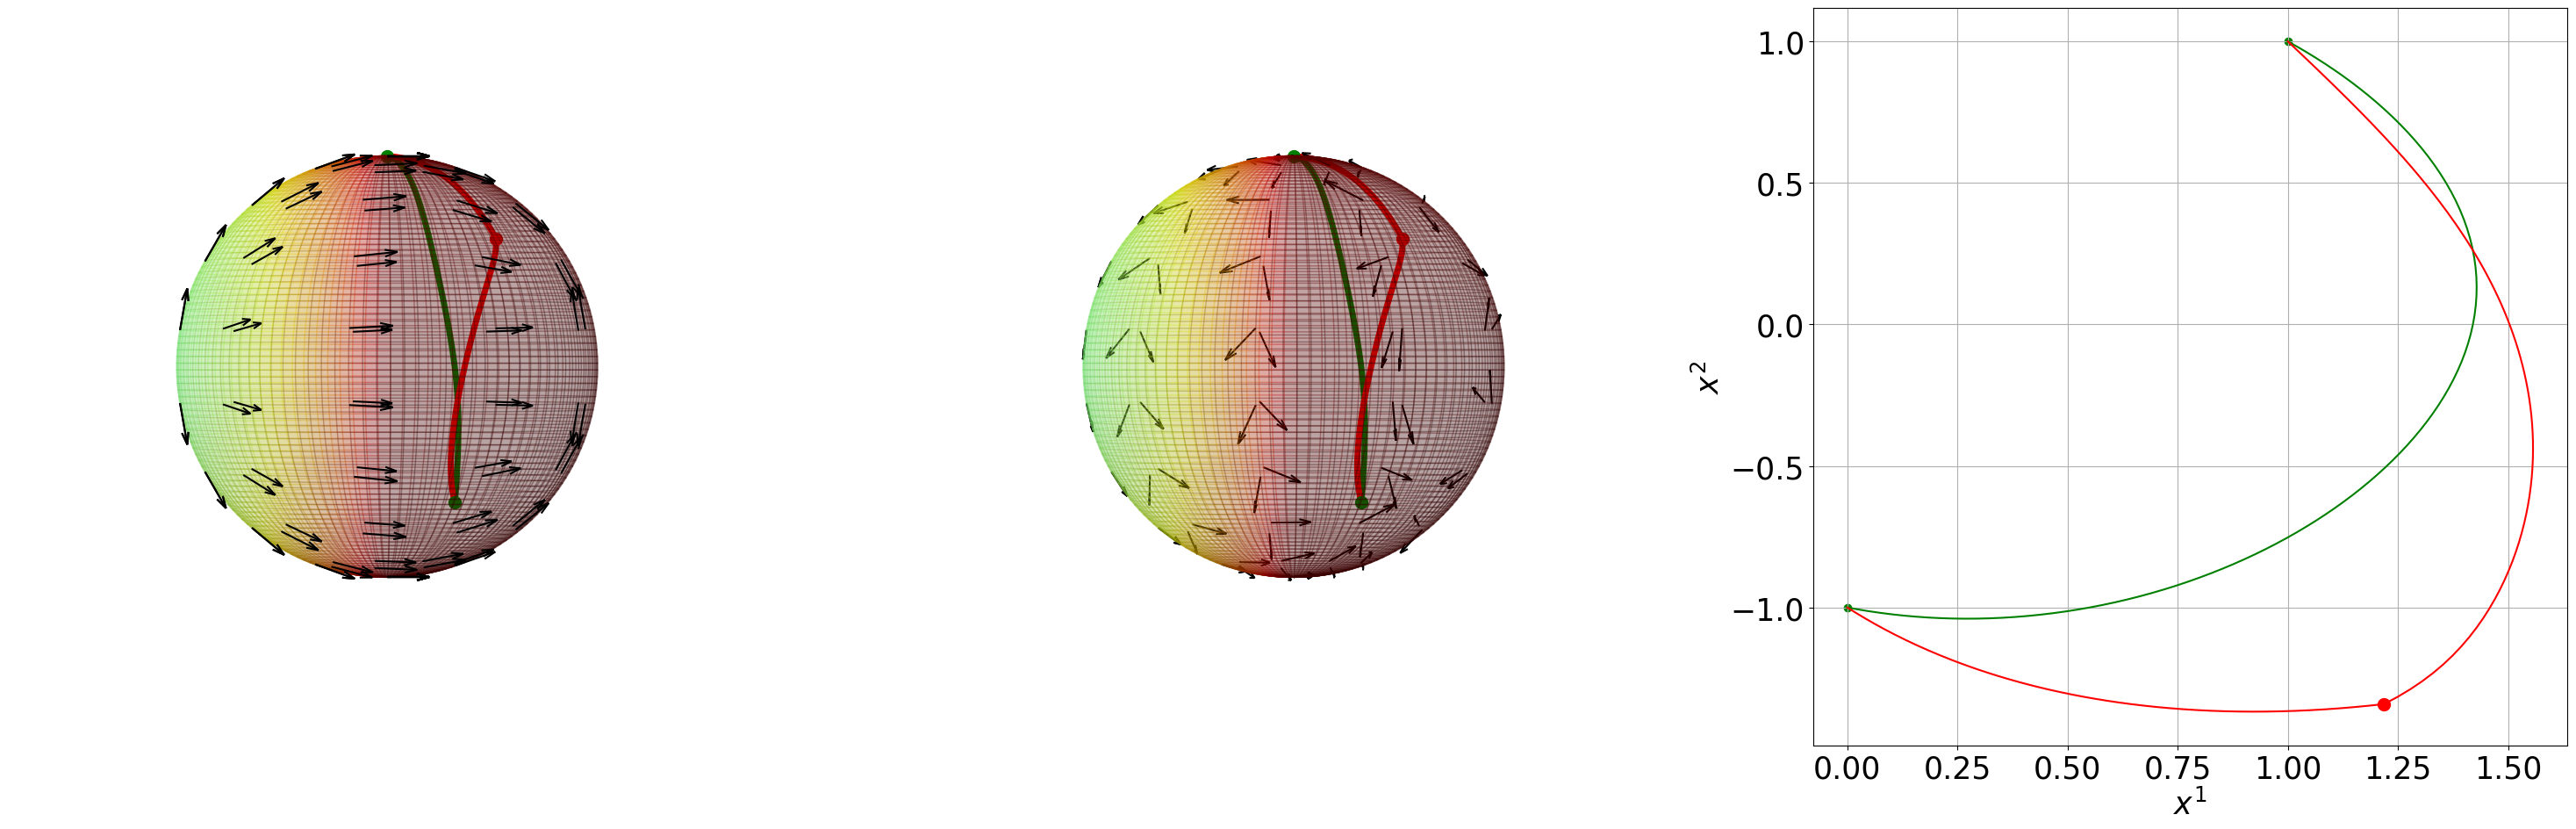

In [16]:
fig = plt.figure(figsize=(30,10))

#%% Plotting Finsler metric 1
ax = fig.add_subplot(131, projection='3d')
plot_sphere = SpherePlot(force_fun=force_fun1)
x1,x2,x3 = plot_sphere.grid(100)
heat_map = plot_sphere.heat_map(0.0, x1,x2,x3)
field = plot_sphere.unit_direction(0.0, 10)
ax.plot_surface(x1, x2, x3, rstride=1, cstride=1, color='cyan', alpha=0.2,
               facecolors=plt.cm.jet(heat_map))
ax.quiver(field[0], field[1], field[2], 
          field[-1][:,:,0], field[-1][:,:,1], field[-1][:,:,2], color='black', length=0.2, normalize=True)
ax.plot(xt[:,0], xt[:,1], xt[:,2], alpha=1.0, color='green', linewidth=5.0)
ax.scatter(xt_tack[T, 0],xt_tack[T,1], xt_tack[T,2], alpha=1.0, color='red',s=100)
ax.plot(xt_tack[:,0], xt_tack[:,1], xt_tack[:,2], alpha=1.0, color='red', linewidth=5.0)
ax.scatter(s2_x0[0], s2_x0[1], s2_x0[2], color='green', alpha=1.0, s=100)
ax.scatter(s2_xT[0], s2_xT[1], s2_xT[2], color='green', alpha=1.0, s=100)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=180., azim=90)

#%% Plotting Finsler metric 2
ax = fig.add_subplot(132, projection='3d')
plot_sphere = SpherePlot(force_fun=force_fun2)
x1,x2,x3 = plot_sphere.grid(100)
heat_map = plot_sphere.heat_map(0.0, x1,x2,x3)
field = plot_sphere.unit_direction(0.0, 10)
ax.plot_surface(x1, x2, x3, rstride=1, cstride=1, color='cyan', alpha=0.2,
               facecolors=plt.cm.jet(heat_map))
ax.quiver(field[0], field[1], field[2], 
          field[-1][:,:,0], field[-1][:,:,1], field[-1][:,:,2], color='black', length=0.2, normalize=True)
ax.plot(xt[:,0], xt[:,1], xt[:,2], alpha=1.0, color='green', linewidth=5.0)
ax.scatter(xt_tack[T,0], xt_tack[T,1], xt_tack[T,2], alpha=1.0, color='red',s=100)
ax.plot(xt_tack[:,0], xt_tack[:,1], xt_tack[:,2], alpha=1.0, color='red', linewidth=5.0)
ax.scatter(s2_x0[0], s2_x0[1], s2_x0[2], color='green', alpha=1.0, s=100)
ax.scatter(s2_xT[0], s2_xT[1], s2_xT[2], color='green', alpha=1.0, s=100)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=180., azim=90)

#plotting sphere
ax = fig.add_subplot(133)
ax.plot(zt[1][:,0],zt[1][:,1], color='green')
ax.plot(zt_tack[1][:,0],zt_tack[1][:,1], color='red')
ax.scatter(zt_tack[1][T,0],zt_tack[1][T,1], color='red', s=100)
ax.scatter(z0[0],z0[1], color='green')
ax.scatter(zT[0],zT[1], color='green')
ax.grid(True)
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')

fig.tight_layout()

save_path = f'{figure_path}riemannian_navigation.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()


## Time-Dependent Tacking for Riemannian Navigation

### Defining Finsler Geometry

In [6]:
def force_fun1(t, z, M):
    
    val = jnp.sin(z)
    
    val2 = jnp.sqrt(jnp.einsum('i,ij,j->', val, M.G(z), val))
    
    return val/val2#jnp.cos(z)*val/val2

In [7]:
def force_fun2(t, z, M):
    
    val = jnp.cos(z)
    
    val2 = jnp.sqrt(jnp.einsum('i,ij,j->', val, M.G(z), val))
    
    return jnp.cos(t)*val/val2#jnp.sin(z)*val/val2

In [8]:
v0 = 1.5

In [9]:
RM = nSphere(dim=2)

z0 = -jnp.linspace(0,1,2)
zT = jnp.ones(2, dtype=jnp.float32)

s2_x0 = RM.f(z0)
s2_xT = RM.f(zT)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [21]:
M1 = RiemannianNavigation(RM=RM,
                         force_fun=lambda t,z: force_fun1(t, z, RM),
                         v0=v0,
                        )

In [22]:
M2 = RiemannianNavigation(RM=RM,
                         force_fun=lambda t, z: force_fun2(t, z, RM),
                         v0=v0,
                        )

### Tack Point Estimation

In [23]:
Geodesic = GEORCE([M2,M1,M2,M2,M1], max_iter=max_iter, T=T, tol=tol, line_search_params={'rho':rho})

In [24]:
zt = Geodesic(0.0,z0,zT, n_tacks=0)
zt_tack = Geodesic(0.0,z0,zT, n_tacks=1)

In [25]:
xt = vmap(M1.f)(zt[1])
xt_tack = vmap(M1.f)(zt_tack[1])

### Plotting Tacks

In [26]:
class SpherePlot(ABC):
    def __init__(self, 
                 force_fun,
                ):
        
        self.M = nSphere(dim=2)
        self.force_fun = lambda t, z: force_fun(t, z, self.M)
        self.params = jnp.ones(2)

    def heat_map(self, t, X, Y, Z)->Array:
        
        z = vmap(lambda x,y,z: vmap(lambda x1,y1,z1: self.M.invf(jnp.stack((x1,y1,z1))))(x,y,z))(X,Y,Z)
        
        heat_map = vmap(lambda z1: vmap(lambda z: jnp.linalg.norm(self.force_fun(t, z)))(z1))(z)
        
        return heat_map
    
    def unit_direction(self, t, n_points:int=100)->Array:
        
        X,Y,Z = self.grid(n_points)
        
        z = vmap(lambda x,y,z: vmap(lambda x1,y1,z1: self.M.invf(jnp.stack((x1,y1,z1))))(x,y,z))(X,Y,Z)
        
        force = vmap(lambda z1: vmap(lambda z: jnp.dot(self.M.Jf(z), self.force_fun(t, z)))(z1))(z)
        
        return X,Y,Z,force
        
    def grid(self, n_points:int=100)->Array:
        
        theta = jnp.linspace(0.0, jnp.pi*1, n_points)
        phi   = jnp.linspace(0.0, jnp.pi*2, n_points)

        # Creating the coordinate grid for the unit sphere.
        x1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
        x2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
        x3 = jnp.outer(jnp.cos(theta), jnp.ones(n_points))
        
        return self.params[0]*x1,self.params[1]*x2,self.params[2]*x3
         

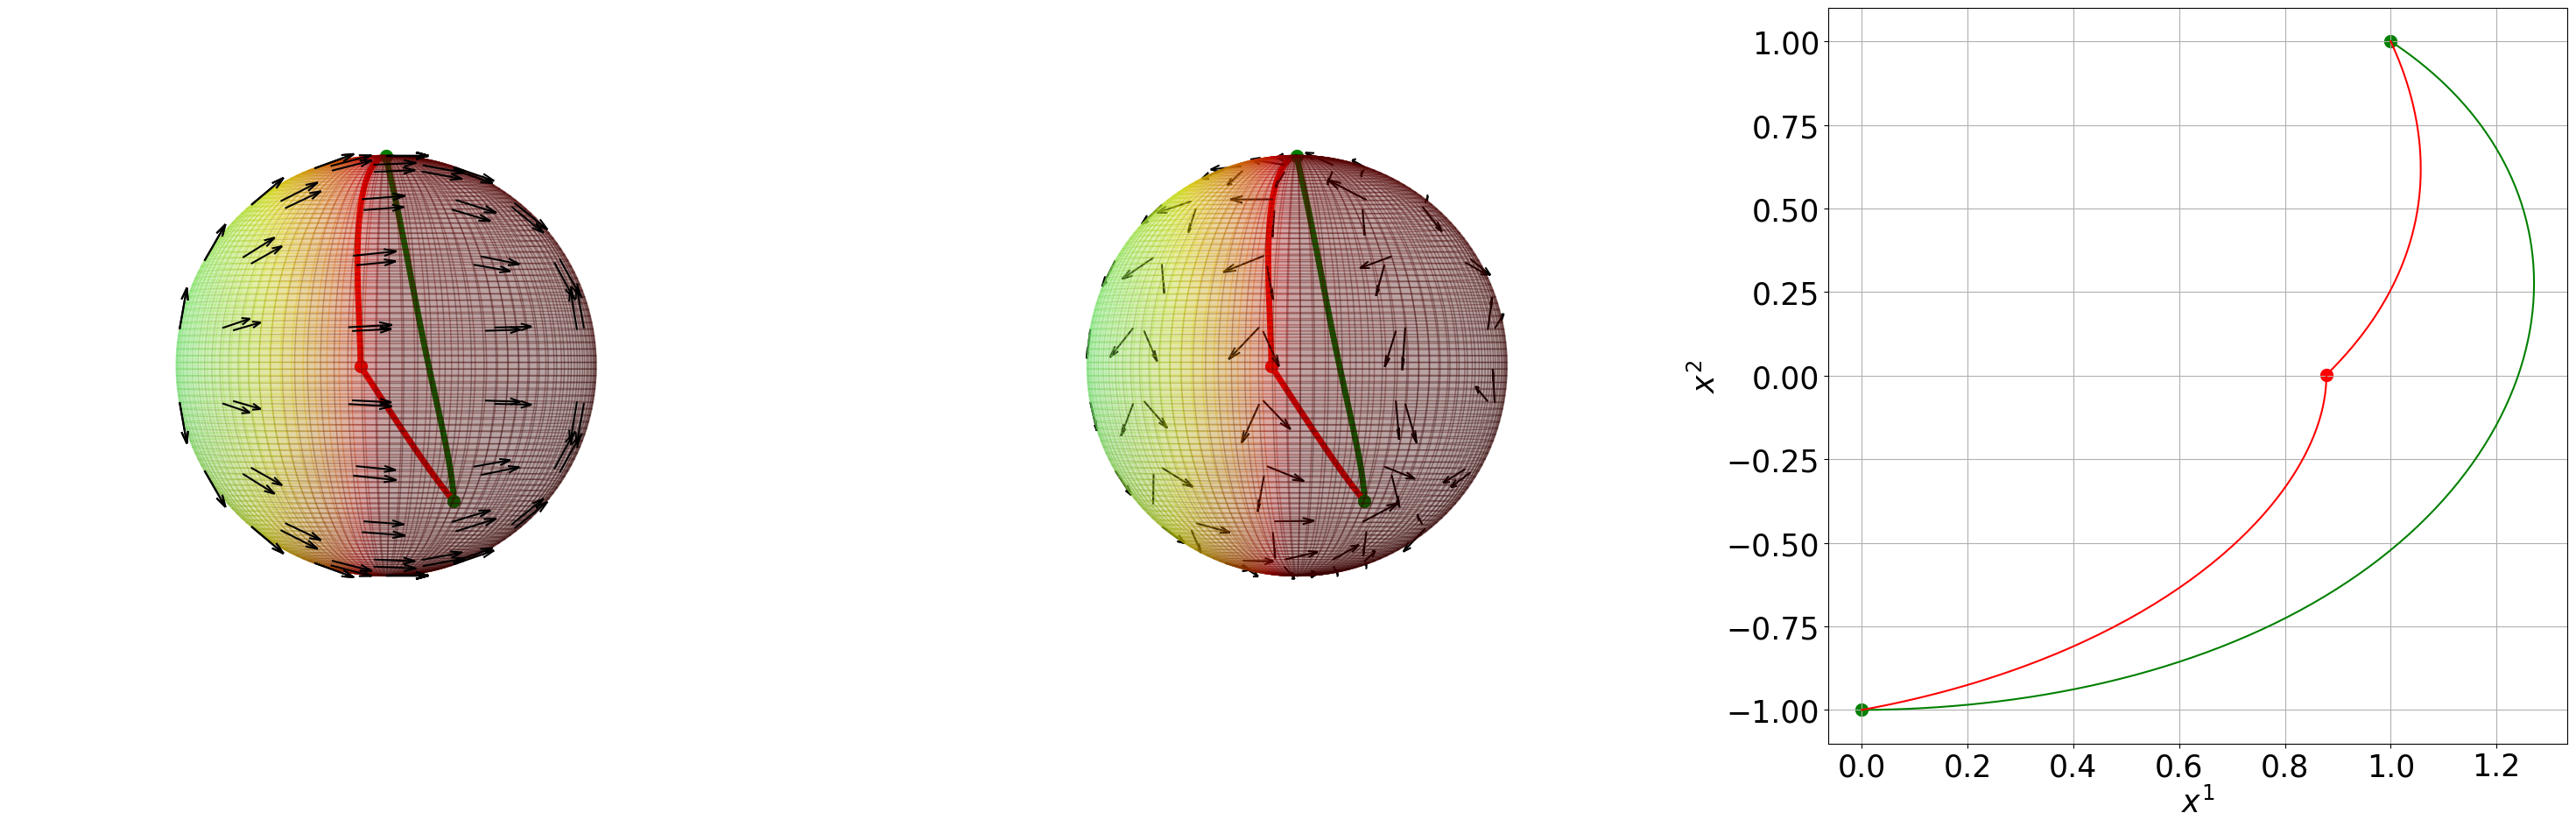

In [27]:
fig = plt.figure(figsize=(30,10))

#%% Plotting Finsler metric 1
ax = fig.add_subplot(131, projection='3d')
plot_sphere = SpherePlot(force_fun=force_fun1)
x1,x2,x3 = plot_sphere.grid(100)
heat_map = plot_sphere.heat_map(0.0, x1,x2,x3)
field = plot_sphere.unit_direction(0.0, 10)
ax.plot_surface(x1, x2, x3, rstride=1, cstride=1, color='cyan', alpha=0.2,
               facecolors=plt.cm.jet(heat_map))
ax.quiver(field[0], field[1], field[2], 
          field[-1][:,:,0], field[-1][:,:,1], field[-1][:,:,2], color='black', length=0.2, normalize=True)
ax.plot(xt[:,0], xt[:,1], xt[:,2], alpha=1.0, color='green', linewidth=5.0)
ax.scatter(xt_tack[T, 0], xt_tack[T,1], xt_tack[T,2], alpha=1.0, color='red',s=100)
ax.plot(xt_tack[:,0], xt_tack[:,1], xt_tack[:,2], alpha=1.0, color='red', linewidth=5.0)
ax.scatter(s2_x0[0], s2_x0[1], s2_x0[2], color='green', alpha=1.0, s=100)
ax.scatter(s2_xT[0], s2_xT[1], s2_xT[2], color='green', alpha=1.0, s=100)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0]), 
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=180., azim=90)

#%% Plotting Finsler metric 2
ax = fig.add_subplot(132, projection='3d')
plot_sphere = SpherePlot(force_fun=force_fun2)
x1,x2,x3 = plot_sphere.grid(100)
heat_map = plot_sphere.heat_map(0.0, x1,x2,x3)
field = plot_sphere.unit_direction(0.0, 10)
ax.plot_surface(x1, x2, x3, rstride=1, cstride=1, color='cyan', alpha=0.2,
               facecolors=plt.cm.jet(heat_map))
ax.quiver(field[0], field[1], field[2], 
          field[-1][:,:,0], field[-1][:,:,1], field[-1][:,:,2], color='black', length=0.2, normalize=True)
ax.plot(xt[:,0], xt[:,1], xt[:,2], alpha=1.0, color='green', linewidth=5.0)
ax.scatter(xt_tack[T,0], xt_tack[T,1], xt_tack[T,2], alpha=1.0, color='red',s=100)
ax.plot(xt_tack[:,0], xt_tack[:,1], xt_tack[:,2], alpha=1.0, color='red', linewidth=5.0)
ax.scatter(s2_x0[0], s2_x0[1], s2_x0[2], color='green', alpha=1.0, s=100)
ax.scatter(s2_xT[0], s2_xT[1], s2_xT[2], color='green', alpha=1.0, s=100)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=180., azim=90)

#plotting sphere
ax = fig.add_subplot(133)
ax.plot(zt[1][:,0],zt[1][:,1], color='green')
ax.plot(zt_tack[1][:,0],zt_tack[1][:,1], color='red')
ax.scatter(zt_tack[1][T,0],zt_tack[1][T,1], s=100, color='red')
ax.scatter(z0[0],z0[1], color='green', s=100)
ax.scatter(zT[0],zT[1], color='green', s=100)
ax.grid(True)
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')


fig.tight_layout()

save_path = f'{figure_path}time_riemannian_navigation.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()

## Rotating Time-Dependent Tack Points

### Defining Finsler Geometry

In [10]:
class EllipticFinsler(ABC):
    def __init__(self,
                 c1=1.0, 
                 c2=1.0,
                 a=1.0,
                 b=1.0,
                 theta=jnp.pi/4
                )->None:
        
        self.c1 = c1
        self.c2 = c2
        self.a = a
        self.b = b
        self.theta = theta
        
    def __call__(self, t, x, v):
        
        c1 = self.c1(t)
        c2 = self.c2(t)
        a = self.a(t)
        b = self.b(t)
        theta = self.theta(t)
        
        x,y = v[0], v[1]
        
        a2 = a**2
        b2 = b**2
        a4 = a**4
        b4 = b**4
        c12 = c1**2
        c22 = c2**2

        f = (-a2*c2*(x*jnp.sin(theta)+y*jnp.cos(theta))-\
             b2*c1*(x*jnp.cos(theta)-y*jnp.sin(theta))+\
             (a4*b2*(x*jnp.sin(theta)+y*jnp.cos(theta))**2+\
              a2*b4*(x*jnp.cos(theta)-y*jnp.sin(theta))**2-\
              a2*b2*c12*(x*jnp.sin(theta)+y*jnp.cos(theta))**2+\
              2*a2*b2*c1*c2*(x*jnp.cos(theta)-y*jnp.sin(theta))*(x*jnp.sin(theta)+y*jnp.cos(theta))-\
              a2*b2*c22*(x*jnp.cos(theta)-y*jnp.sin(theta))**2)**(1/2))/(a2*b2-a2*c22-b2*c12)
        
        return f

In [11]:
phi=lambda t: t
theta = lambda t: 0.0
a= lambda t: 2
b= lambda t: a(t)
c1 = lambda t: -(3/2)*jnp.cos(phi(t))
c2 = lambda t: -(3/2)*jnp.sin(phi(t))

Falpha = EllipticFinsler(c1=c1,c2=c2, a=a,b=b,theta=theta)
Malpha = LorentzFinslerManifold(F=Falpha)

In [12]:
phi=lambda t: t
theta = lambda t: 0.0
a= lambda t: 2
b= lambda t: a(t)
c1 = lambda t: (3/2)*jnp.cos(phi(t))
c2 = lambda t: (3/2)*jnp.sin(phi(t))

Fbeta = EllipticFinsler(c1=c1,c2=c2, a=a,b=b,theta=theta)
Mbeta = LorentzFinslerManifold(F=Fbeta)

### Estimating Tack Points

In [13]:
z0 = jnp.array([0.,0.])
zT = jnp.array([2.,8.])

In [14]:
tack_metrics = [Malpha,Mbeta,Malpha,Mbeta,Malpha]
reverse_tack_metrics = [Mbeta, Malpha, Mbeta, Malpha, Mbeta]
Geodesic = GEORCE(tack_metrics, max_iter=max_iter, T=T, tol=tol, line_search_params={'rho':rho})
ReverseGeodesic = GEORCE(reverse_tack_metrics, max_iter=max_iter, T=T, tol=tol, line_search_params={'rho':rho})

In [21]:
zt_tacks = []
zt_reverse_tacks = []
for i in range(0,len(tack_metrics)):
    zt1 = Geodesic(0.0, z0, zT, n_tacks=i)
    print(zt1[0][-1])
    print(zt1[-1])
    zt2 = ReverseGeodesic(0.0, z0, zT, n_tacks=i)
    print(zt2[0][-1])
    print(zt2[-1])
    zt_tacks.append(zt1[1])
    zt_reverse_tacks.append(zt2[1])

5.0917997
4
3.1028671
4
7.1806707
5
4.1494064
1000
9.733946
5
6.6558623
5
11.381795
5
9.148626
5
9.052578
4
7.5903573
4


In [16]:
indicatrix1 = Malpha.indicatrix(0.0, jnp.zeros(2), grid=jnp.linspace(-5,5,1000), eps=1e-6)
indicatrix2 = Mbeta.indicatrix(0.0, jnp.zeros(2), grid=jnp.linspace(-5,5,1000), eps=1e-6)

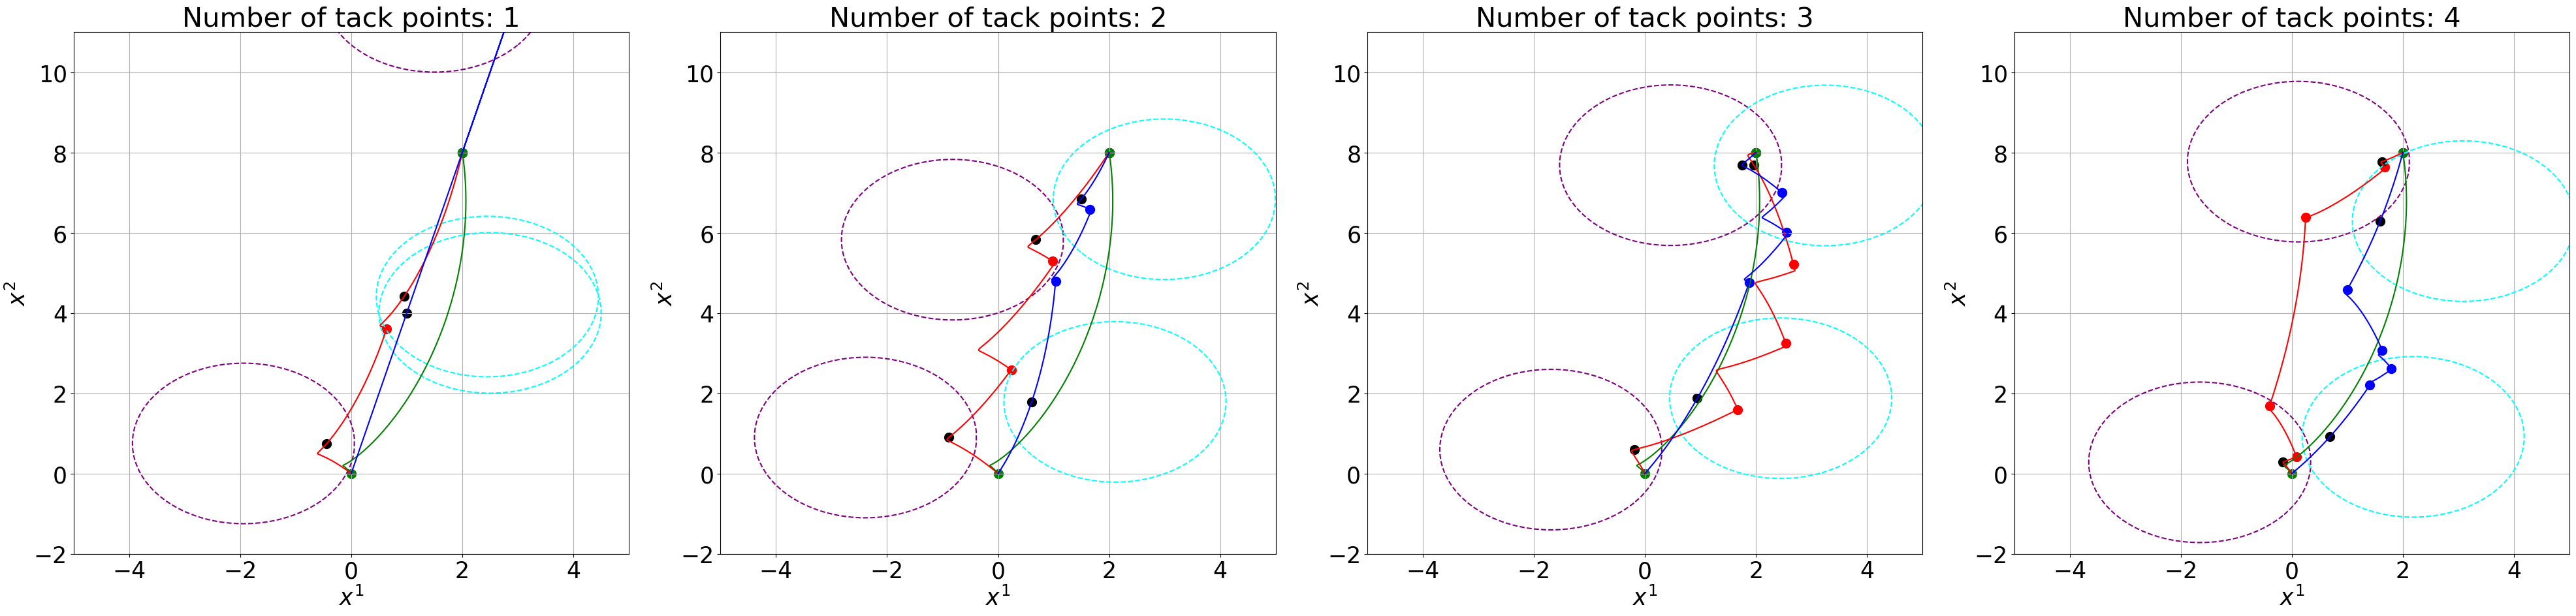

In [19]:
fig = plt.figure(figsize=((len(tack_metrics)-1)*10,10))

xscales = [-5.0, 5.0]
yscales = [-2.0, 11.0]

base_curve = zt_tacks[0]
for i in range(1,len(tack_metrics)):
    ax = fig.add_subplot(1,len(tack_metrics)-1,i)
    
    if i == 1:
        for j in range(0,i+1):
            if j % 2 == 0:
                i1_color = "purple"
                i2_color = "cyan"
                
                i1 = indicatrix1+zt_tacks[i][T//2+j*T]
                i2 = indicatrix2+zt_reverse_tacks[i][T//2+j*T]
            else:
                i1_color = "cyan"
                i2_color = "purple"
                
                i1 = indicatrix2+zt_tacks[i][T//2+j*T]
                i2 = indicatrix1+zt_reverse_tacks[i][T//2+j*T]
            ax.scatter(zt_tacks[i][T//2+j*T,0], zt_tacks[i][T//2+j*T,1], color='black', s=100)
            ax.scatter(zt_reverse_tacks[i][T//2+j*T,0], zt_reverse_tacks[i][T//2+j*T,1], color='black', s=100)
            ax.scatter(zt_tacks[i][T+j*T,0], zt_tacks[i][T+j*T,1], color='red', s=100)
            ax.scatter(zt_reverse_tacks[i][T+j*T,0], zt_reverse_tacks[i][T+j*T,1], color='blue', s=100)
            ax.plot(i1[:,0], i1[:,1], color=i1_color, linestyle='dashed')
            ax.plot(i2[:,0], i2[:,1], color=i2_color, linestyle='dashed')
    else:
        for j in range(0,i+1):
            ax.scatter(zt_tacks[i][T+j*T,0], zt_tacks[i][T+j*T,1], color='red', s=100)
            ax.scatter(zt_reverse_tacks[i][T+j*T,0], zt_reverse_tacks[i][T+j*T,1], color='blue', s=100)
            if (j == 0) or (j==i):
                i1_color = 'purple'
                i2_color = 'cyan'
                i1 = indicatrix1+zt_tacks[i][T//2+j*T]
                i2 = indicatrix2+zt_reverse_tacks[i][T//2+j*T]
                ax.scatter(zt_tacks[i][T//2+j*T,0], zt_tacks[i][T//2+j*T,1], color='black', s=100)
                ax.scatter(zt_reverse_tacks[i][T//2+j*T,0], zt_reverse_tacks[i][T//2+j*T,1], color='black', s=100)
                ax.plot(i1[:,0], i1[:,1], color=i1_color, linestyle='dashed')
                ax.plot(i2[:,0], i2[:,1], color=i2_color, linestyle='dashed')
            
    ax.scatter(z0[0], z0[1], color='green', s=100)
    ax.scatter(zT[0], zT[1], color='green', s=100)
    ax.plot(base_curve[:,0], base_curve[:,1], color='green')
    ax.plot(zt_tacks[i][:,0], zt_tacks[i][:,1], color='red')
    ax.plot(zt_reverse_tacks[i][:,0], zt_reverse_tacks[i][:,1], color='blue')
    ax.set_title(f"Number of tack points: {i}")
    
    ax.set_xlabel(r'$x^{1}$')
    ax.set_ylabel(r'$x^{2}$')
    ax.set_xlim(xscales[0], xscales[1])
    ax.set_ylim(yscales[0], yscales[1])
    ax.grid(True)

fig.tight_layout()

save_path = f'{figure_path}time_circle_finsler.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')
    
plt.show()